<a href="https://colab.research.google.com/github/Jenarth/SCS3250-Group-2-Final-Project/blob/master/3_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **PHASE 3: MACHINE LEARNING**
---

## Linear Regression with Weekdays - Part 1

In [0]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

In [0]:
# Let's import the dataset

url = 'https://raw.githubusercontent.com/Jenarth/SCS3250-Group-2-Final-Project/master/Final%20Dataset.csv'
df = pd.read_csv(url, header = 0, sep =',',parse_dates=['Date'])

In [29]:
df.head()

,Date,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
0,2017-03-01,2017,3,2017-03,1,Wednesday,False,13.1,-1.9,5.6,0.116129,5.483871,18.4,2.490323,15.909677,0.0,74235,100664,187314,243965,115524,41759,65258,709669,1538388,False,1.684403e+06,1.885102e+06,1.483705e+06
1,2017-03-02,2017,3,2017-03,2,Thursday,False,-1.3,-6.4,-3.9,0.116129,-4.016129,0.2,2.490323,-2.290323,0.5,73575,98834,193721,251245,115976,41975,64723,710233,1550282,False,1.667167e+06,1.877280e+06,1.457055e+06
2,2017-03-03,2017,3,2017-03,3,Friday,False,-4.3,-8.1,-6.2,0.116129,-6.316129,0.0,2.490323,-2.490323,0.5,65999,90692,176474,233488,104386,38029,58671,645929,1413668,False,1.513443e+06,1.722796e+06,1.304090e+06
3,2017-03-04,2017,3,2017-03,4,Saturday,False,-6.5,-11.9,-9.2,0.116129,-9.316129,0.2,2.490323,-2.290323,0.5,6852,3517,58477,87326,1518,0,1792,102982,262464,False,3.363528e+05,5.477078e+05,1.249978e+05
4,2017-03-05,2017,3,2017-03,5,Sunday,False,-0.4,-10.6,-5.5,0.116129,-5.616129,0.0,2.490323,-2.490323,0.5,5933,2917,35034,62331,1234,0,1135,62998,171582,False,2.407631e+05,3.932424e+05,8.828385e+04


In [30]:
# Convert weekdays into integers

weekday = {'Monday':1 , 'Tuesday':2 , 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
df.Weekday = [weekday[item] for item in df.Weekday]
df.head()

,Date,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
0,2017-03-01,2017,3,2017-03,1,3,False,13.1,-1.9,5.6,0.116129,5.483871,18.4,2.490323,15.909677,0.0,74235,100664,187314,243965,115524,41759,65258,709669,1538388,False,1.684403e+06,1.885102e+06,1.483705e+06
1,2017-03-02,2017,3,2017-03,2,4,False,-1.3,-6.4,-3.9,0.116129,-4.016129,0.2,2.490323,-2.290323,0.5,73575,98834,193721,251245,115976,41975,64723,710233,1550282,False,1.667167e+06,1.877280e+06,1.457055e+06
2,2017-03-03,2017,3,2017-03,3,5,False,-4.3,-8.1,-6.2,0.116129,-6.316129,0.0,2.490323,-2.490323,0.5,65999,90692,176474,233488,104386,38029,58671,645929,1413668,False,1.513443e+06,1.722796e+06,1.304090e+06
3,2017-03-04,2017,3,2017-03,4,6,False,-6.5,-11.9,-9.2,0.116129,-9.316129,0.2,2.490323,-2.290323,0.5,6852,3517,58477,87326,1518,0,1792,102982,262464,False,3.363528e+05,5.477078e+05,1.249978e+05
4,2017-03-05,2017,3,2017-03,5,7,False,-0.4,-10.6,-5.5,0.116129,-5.616129,0.0,2.490323,-2.490323,0.5,5933,2917,35034,62331,1234,0,1135,62998,171582,False,2.407631e+05,3.932424e+05,8.828385e+04


In [31]:
# Let's create a new dataset to only select the month of January

jan_df = df[(df.Month == 1)& (df.Year != 2017)]
jan_df.head(2)

,Date,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
306,2018-01-01,2018,1,2018-01,1,1,True,-7.9,-18.6,-13.3,-4.383871,-8.916129,0.2,1.929032,-1.729032,0.0,6307,2688,28512,47203,700,0,954,64691,151055,True,NaN,NaN,NaN
307,2018-01-02,2018,1,2018-01,2,2,False,-7.1,-12.5,-9.8,-4.383871,-5.416129,0.0,1.929032,-1.929032,0.0,57133,78465,148978,186825,89191,32313,51693,551372,1195970,True,NaN,NaN,NaN


Let's plot our data points on a graph to eyeball our dataset. We will take a look specifically at Union Station, a central station in Toronto.

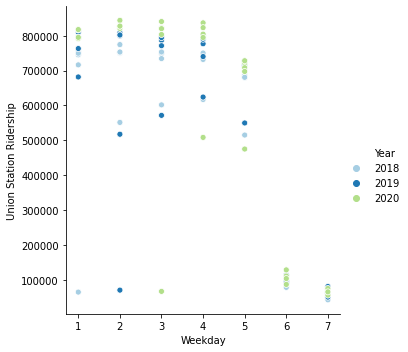

In [32]:
sns.relplot(x='Weekday',y='Union Station Ridership', data=jan_df,hue='Year',palette='Paired')

We notice one outliner by year where there is very little Riderships: the 1st of January.

Let's check our average Riderships for Union Station.

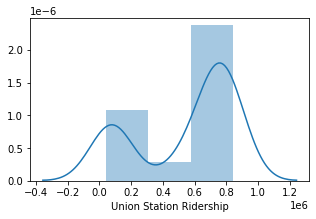

In [33]:
plt.figure(figsize=(5,3))
plt.tight_layout()
sns.distplot(jan_df['Union Station Ridership'])

In [0]:
# Now let's divide the data into attributes ('Weekday') and labels ('Union Station Riderships').

X=jan_df['Weekday'].values.reshape(-1,1)
y=jan_df['Union Station Ridership'].values.reshape(-1,1)

In [0]:
#Split the data to 20% of the data to test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [36]:
# Train the algorithm

regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

[985859.3182057]
[[-113608.43190178]]


In [0]:
y_pred = regressor.predict(X_test)

In [39]:
# Let's use our test data and see how accurately our algorithm predicts the percentage score.

df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()}).round()
df

,Actual,Predicted
0,601694,645034.0
1,772849,645034.0
2,716820,417817.0
3,753435,645034.0
4,71131,190600.0
5,681773,872251.0
6,740309,531426.0
7,809108,758642.0
8,624124,531426.0
9,836998,531426.0


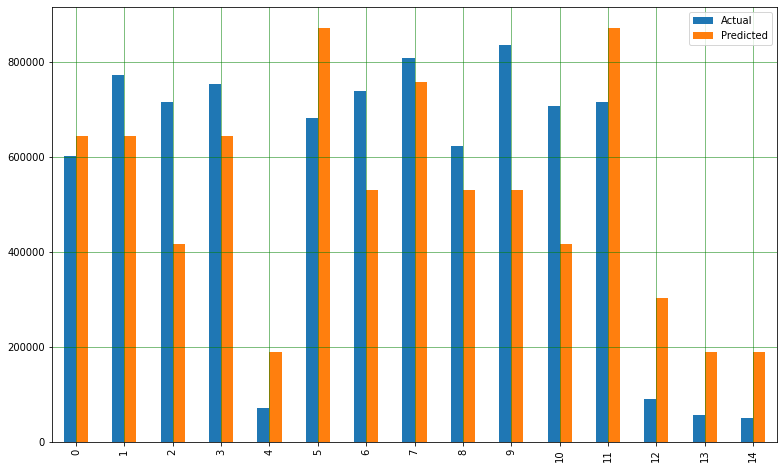

In [40]:
# Let's plot our results 


df1 = df.head(15)
df1.plot(kind='bar',figsize=(13,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## Linear Regression with Weekdays - Part 2

In [0]:
df = pd.read_csv(url, header = 0, sep =',',parse_dates=['Date'])

In [42]:
# Let's remove the outliers as well as the holidays period

data= df.loc[(-df.Holiday)&(-df.Outlier)]
data.head(5)

,Date,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
0,2017-03-01,2017,3,2017-03,1,Wednesday,False,13.1,-1.9,5.6,0.116129,5.483871,18.4,2.490323,15.909677,0.0,74235,100664,187314,243965,115524,41759,65258,709669,1538388,False,1.684403e+06,1.885102e+06,1.483705e+06
1,2017-03-02,2017,3,2017-03,2,Thursday,False,-1.3,-6.4,-3.9,0.116129,-4.016129,0.2,2.490323,-2.290323,0.5,73575,98834,193721,251245,115976,41975,64723,710233,1550282,False,1.667167e+06,1.877280e+06,1.457055e+06
2,2017-03-03,2017,3,2017-03,3,Friday,False,-4.3,-8.1,-6.2,0.116129,-6.316129,0.0,2.490323,-2.490323,0.5,65999,90692,176474,233488,104386,38029,58671,645929,1413668,False,1.513443e+06,1.722796e+06,1.304090e+06
3,2017-03-04,2017,3,2017-03,4,Saturday,False,-6.5,-11.9,-9.2,0.116129,-9.316129,0.2,2.490323,-2.290323,0.5,6852,3517,58477,87326,1518,0,1792,102982,262464,False,3.363528e+05,5.477078e+05,1.249978e+05
4,2017-03-05,2017,3,2017-03,5,Sunday,False,-0.4,-10.6,-5.5,0.116129,-5.616129,0.0,2.490323,-2.490323,0.5,5933,2917,35034,62331,1234,0,1135,62998,171582,False,2.407631e+05,3.932424e+05,8.828385e+04


In [43]:
# Convert weekdays into integers

weekday = {'Monday':1 , 'Tuesday':2 , 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
data.Weekday = [weekday[item] for item in data.Weekday]
data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,Date,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
0,2017-03-01,2017,3,2017-03,1,3,False,13.1,-1.9,5.6,0.116129,5.483871,18.4,2.490323,15.909677,0.0,74235,100664,187314,243965,115524,41759,65258,709669,1538388,False,1.684403e+06,1.885102e+06,1.483705e+06
1,2017-03-02,2017,3,2017-03,2,4,False,-1.3,-6.4,-3.9,0.116129,-4.016129,0.2,2.490323,-2.290323,0.5,73575,98834,193721,251245,115976,41975,64723,710233,1550282,False,1.667167e+06,1.877280e+06,1.457055e+06
2,2017-03-03,2017,3,2017-03,3,5,False,-4.3,-8.1,-6.2,0.116129,-6.316129,0.0,2.490323,-2.490323,0.5,65999,90692,176474,233488,104386,38029,58671,645929,1413668,False,1.513443e+06,1.722796e+06,1.304090e+06
3,2017-03-04,2017,3,2017-03,4,6,False,-6.5,-11.9,-9.2,0.116129,-9.316129,0.2,2.490323,-2.290323,0.5,6852,3517,58477,87326,1518,0,1792,102982,262464,False,3.363528e+05,5.477078e+05,1.249978e+05
4,2017-03-05,2017,3,2017-03,5,7,False,-0.4,-10.6,-5.5,0.116129,-5.616129,0.0,2.490323,-2.490323,0.5,5933,2917,35034,62331,1234,0,1135,62998,171582,False,2.407631e+05,3.932424e+05,8.828385e+04


Let's plot our data points on a graph. Here again will take a look specifically at Union Station, a central station in Toronto.

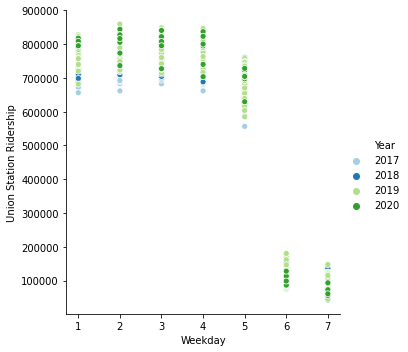

In [44]:
sns.relplot(x='Weekday',y='Union Station Ridership', data=data,hue='Year',palette='Paired')

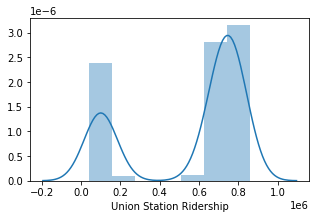

In [45]:
plt.figure(figsize=(5,3))
plt.tight_layout()
sns.distplot(data['Union Station Ridership'])

In [0]:
# Now let's divide the data into attributes ('Weekday') and labels ('Union Station Riderships').

X=data['Weekday'].values.reshape(-1,1)
y=data['Union Station Ridership'].values.reshape(-1,1)

In [0]:
#Split the data to 20% of the data to test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [48]:
# Train the algorithm

regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [49]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

[1050212.44404898]
[[-122555.76497414]]


In [0]:
y_pred = regressor.predict(X_test)

In [51]:
# Let's use our test data and see how accurately our algorithm predicts the percentage score.

df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()}).round()
df

,Actual,Predicted
0,796254,805101.0
1,744960,559989.0
2,715057,805101.0
3,709744,805101.0
4,806557,805101.0
...,...,...
194,727884,559989.0
195,726795,805101.0
196,731299,437434.0
197,751670,559989.0


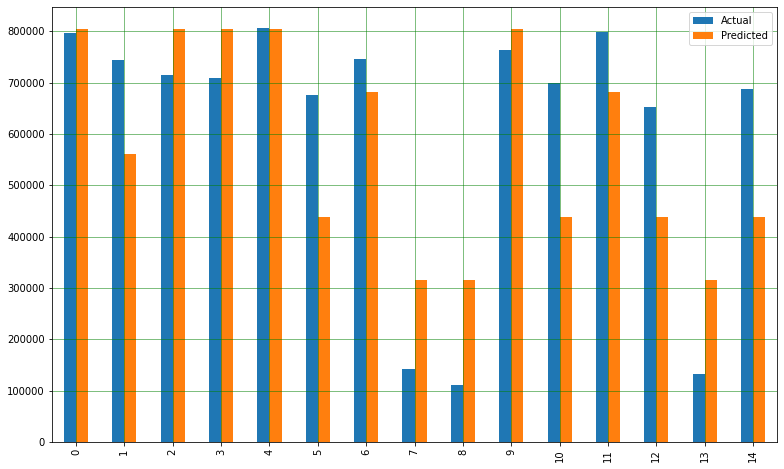

In [52]:
# Let's plot our results 


df1 = df.head(15)
df1.plot(kind='bar',figsize=(13,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Our initial thought was that by removing the outliers and expanding the data frame to cover the whole year would lead to a more precise predictive model.
After running the analysis, the model studied in part 2 seems more accurate.

## Multiple Linear Regression with 2 Variables

In [0]:
df = pd.read_csv(url,index_col='Date', parse_dates=True)

In [54]:
# Let's convert weekdays into integers

weekday = {'Monday':1 , 'Tuesday':2 , 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
df.Weekday = [weekday[item] for item in df.Weekday]
df.head()

,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-01,2017,3,2017-03,1,3,False,13.1,-1.9,5.6,0.116129,5.483871,18.4,2.490323,15.909677,0.0,74235,100664,187314,243965,115524,41759,65258,709669,1538388,False,1.684403e+06,1.885102e+06,1.483705e+06
2017-03-02,2017,3,2017-03,2,4,False,-1.3,-6.4,-3.9,0.116129,-4.016129,0.2,2.490323,-2.290323,0.5,73575,98834,193721,251245,115976,41975,64723,710233,1550282,False,1.667167e+06,1.877280e+06,1.457055e+06
2017-03-03,2017,3,2017-03,3,5,False,-4.3,-8.1,-6.2,0.116129,-6.316129,0.0,2.490323,-2.490323,0.5,65999,90692,176474,233488,104386,38029,58671,645929,1413668,False,1.513443e+06,1.722796e+06,1.304090e+06
2017-03-04,2017,3,2017-03,4,6,False,-6.5,-11.9,-9.2,0.116129,-9.316129,0.2,2.490323,-2.290323,0.5,6852,3517,58477,87326,1518,0,1792,102982,262464,False,3.363528e+05,5.477078e+05,1.249978e+05
2017-03-05,2017,3,2017-03,5,7,False,-0.4,-10.6,-5.5,0.116129,-5.616129,0.0,2.490323,-2.490323,0.5,5933,2917,35034,62331,1234,0,1135,62998,171582,False,2.407631e+05,3.932424e+05,8.828385e+04


In [0]:
# Build linear regression model using Weekday and Precipitation as predictors
# Split data into predictors X and output Y

predictors = ['Weekday','Total Precip (mm)']
X= df[predictors]
y=df['Union Station Ridership'].values.reshape(-1,1)

In [0]:
# Initialise and fit model
lm = LinearRegression()
model = lm.fit(X, y)

Instead of calulcating the values for alpha and betas, we have to call .intercept for alpha, and .coef_ for an array with our coefficients.



In [57]:
print(f'alpha = {model.intercept_}')
print(f'betas = {model.coef_}')

alpha = [966292.03323924]
betas = [[-107545.69052024   -1043.23097587]]


We can predict the values by using .predict()

In [58]:
y_pred = model.predict(X)
y_pred

array([[624459.51172257],
       [535900.6249631 ],
       [428563.58063804],
       ...,
       [532875.25513309],
       [427416.02656458],
       [319766.01294676]])

In [59]:
new_X = [[7, 0.2]]
print(model.predict(new_X))

[[213263.55340238]]


Now that we have our predicting model, let's randomly pick a day and assess how far (or close) our model is from reality.

In [60]:
df[['Weekday','Total Precip (mm)','Union Station Ridership']].tail(15)

,Weekday,Total Precip (mm),Union Station Ridership
Date,,,
2020-02-15,6,0.4,113314
2020-02-16,7,0.4,90869
2020-02-17,1,1.0,84243
2020-02-18,2,8.6,773600
2020-02-19,3,0.0,795204
2020-02-20,4,1.0,800284
2020-02-21,5,0.2,703123
2020-02-22,6,0.2,127953
2020-02-23,7,0.8,93485


In [61]:
# Let's look at the 18th of February
prediction_1 = [[2, 8.6]]
print(model.predict(prediction_1))

[[742228.86580631]]


The model predicted 742,228 riderships while the actual number was 773,600: the prediction was pretty close.

In [62]:
# Let's look at the 26th of February 2020
prediction_2 = [[3, 11.8]]
print(model.predict(prediction_2))

[[631344.83616329]]


The model predicted 631,344 riderships while the actual number was 727,372. The prediction here was not as accurate.